# 6. Classification, Regression
This section will cover logistic regression (which is a classification model, not regression) and linear regression. Once you can train both of these models, you know how to do both classification and regression in their simplest way possible. I first demonstrate how to train a logistic regression using the Iris dataset. As an exercise, you will train a linear regression on the Boston housing dataset.

This section will put together what we've learned so far, e.g. `session`, `placeholder`, `variable`, etc. This section might seem hard at first, but the only new concept that will be introduced here is the `GradientDescentOptimizer`. As long as you understand the code step by step, it should be ok.

## Logistic Regression

This example is partially adopted from [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.12/tutorials/mnist/pros/) tutorial from TensorFlow official website.

### Task

Classify a dataset of hand-written digits (0 through 9).

### Data

Let's load the data first. Thankfully, TensorFlow provided us a nice API. The data is also already split into train, validation and test set. In general, the data is much less clean.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's take a look at the first image to get a sense of what is inside. Note that `next_batch` is an API provided by TensorFlow to get the next `n` images from the dataset. You generally have to code this up yourself.

In [2]:
batch = mnist.train.next_batch(1) # get one image from the data
plotData = batch[0]
plotData

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

There are $28\times 28=784$ pixels. $0$ means black and $1$ means white. Let's reshape it and use `matplotlib` to make it an image.

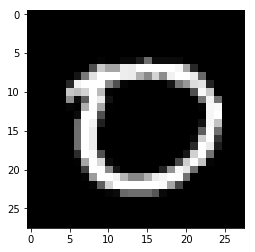

In [3]:
plotData = plotData.reshape(28, 28) # reshape to make image a matirx
plt.gray() # use this line if you don't want to see it in color
plt.imshow(plotData)
plt.show()

### Overview

We will build a softmax regression. Softmax regression is just a multi-class generalization of the logistic regression model:

$Y=softmax(WX+b)$
where

$Y: N \times K$. Labels. The labels are one-hot encoded.

$X: N \times M$. Features.

$W: M \times N$. Weights.

$b: K$. Bias

Here, $N$ can either be the train, validation, test sample size or the mini-batch size, depending on which part of the process you're in. $M$ is the number of features (784 in this case) and $K$ is the number of classes (10 in this case).

I really like to write down all the matrix dimensions before I start any coding. This way, I can avoid matrix dimension errors later on. This is kind of like creating an outline of your essay before you start drafting it.

The loss we would like to optimize is the cross-entropy loss, averaged over the sample size:

$$\frac{-\sum_{n=1}^N \sum_{k=1}^K y_{n,k} log(\hat{y}_{n,k})}{N}$$

We will train this using gradient descent. 

Coding of this model is a six step process:
1. Define variables and placeholders.
2. Define the model.
3. Define the loss function.
4. Define the optimizer.
5. Train the model, i.e. initialize variables and run optimizer.
6. Evaluate the model.

This is the same for any other models. Neural nets will have these steps too!

### Variables and Placeholders

$Y,X$ will be a placeholder, because we will feed in datasets with different shapes.

In [4]:
M = 784
K = 10

In [5]:
X = tf.placeholder(tf.float32, shape=[None, M])
Y = tf.placeholder(tf.float32, shape=[None, K])

$W,b$ will be variables, because we would like to mutate them every epoch via the gradient descent.

In [6]:
W = tf.Variable(tf.zeros([M, K])) # the variables will be all zeros initially
b = tf.Variable(tf.zeros([K]))

### Model
Softmax regression model is a one liner!

In [7]:
Yhat = tf.nn.softmax(X @ W + b)

### Loss
The cross-entropy loss is also a one liner! Make sure to compare it with the equation above and check that it's doing what it's supposed to. We will also define accuracy for evaluating the result on the test set.

In [8]:
loss               = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(Yhat), axis=1))
# choose predictions from 10 classes and compare them with the true labels
correct_prediction = tf.equal(tf.argmax(Yhat, 1), tf.argmax(Y, 1))           
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

### Optimizer
Here's somethig new to learn! `GradientDescentOptimizer` takes in the objective that we would like to minimize. When we run this optimizer in a session, it will look for all trainable variables (or the specified list of variables, if any) and update them. There are many other optimizers e.g. `AdagradOptimizer`, `AdamOptimizer`. Find your favorite!

In [9]:
learning_rate = 0.01 # this is a hyperparameter to tune
optimizer = tf.train.GradientDescentOptimizer(learning_rate) # first initialize an optimizer
update = optimizer.minimize(loss) # then pass in the objective you would like to minimize

### Initialize variables and run optimizer, evaluate the model
The final step is to train the model, and then to evaluate it. We do these in one go. 
We have 25 epochs. Within each epoch, we go through the dataset batch by batch. In each bath, we `sess.run` two variables: `update` and `loss`. Running `update` applies backpropagation to the graph and updates the variables relevant to minimizing the objective. In this case `W` and `b` are updated. Running `loss` just extracts the objective so that we can keep track of how well our model is being trained.

In [10]:
num_epochs  = 25
batch_size  = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # remember, you need to initialize variables first
    total_batch = int(mnist.train.num_examples/batch_size)
    for epoch in range(num_epochs):
        average_cost = 0 # print cost per epoch
        for _ in range(total_batch):
            batch_X, batch_Y = mnist.train.next_batch(batch_size)
            _, c = sess.run([update, loss], feed_dict={X: batch_X, 
                                                          Y: batch_Y}) # evaluate `update` and `loss`
            average_cost += c / total_batch
        print("Epoch:",epoch,"Cost:",average_cost)
        
    print("Test Accuracy:", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels}))

Epoch: 0 Cost: 1.18395111539
Epoch: 1 Cost: 0.665367322835
Epoch: 2 Cost: 0.552765985836
Epoch: 3 Cost: 0.498695070256
Epoch: 4 Cost: 0.465495848168
Epoch: 5 Cost: 0.4425742106
Epoch: 6 Cost: 0.425507432331
Epoch: 7 Cost: 0.412195533135
Epoch: 8 Cost: 0.401369705525
Epoch: 9 Cost: 0.392432074791
Epoch: 10 Cost: 0.384792247523
Epoch: 11 Cost: 0.378197459416
Epoch: 12 Cost: 0.372437060259
Epoch: 13 Cost: 0.367369769676
Epoch: 14 Cost: 0.362621878169
Epoch: 15 Cost: 0.358624564409
Epoch: 16 Cost: 0.35492008025
Epoch: 17 Cost: 0.35138198858
Epoch: 18 Cost: 0.348352879177
Epoch: 19 Cost: 0.345445586416
Epoch: 20 Cost: 0.342711562379
Epoch: 21 Cost: 0.340259887657
Epoch: 22 Cost: 0.337946226272
Epoch: 23 Cost: 0.335711251822
Epoch: 24 Cost: 0.33367082799
Test Accuracy: 0.9136


### Done!
We have 92% ish accuracy. How good is this? To cite the `TensorFlow` documentation:

> Getting 92% accuracy on MNIST is bad. It's almost embarrassingly bad. In this section, we'll fix that, jumping from a very simple model to something moderately sophisticated: a small convolutional neural network. This will get us to around 99.2% accuracy -- not state of the art, but respectable.

We are not going to introduce CNNs in this workshop, but you should take a look to aim for 99+% accuracy!

## Exercise
Train a linear regression using gradient descent (no closed form!) that predicts housing prices in Boston from other covariates provided. Follow the six steps above. Plot the loss and observe that it goes down.

(Optional) Fit a LASSO. Fit a Ridge.

In [11]:
from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()

In [12]:
df = pd.DataFrame(boston.data)
df.columns = boston.feature_names
df['PRICE'] = boston.target

In [13]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
